# 1. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import itertools
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [2]:
from MFLUSolution import *

In [3]:
from selection_and_operators.mutation import swap_stages_slots_mutation, inversion_mutation, shuffle_mutation
from selection_and_operators.crossover import cycle_crossover, partially_matched_crossover, swap_time_slots_crossover
from selection_and_operators.selection import tournament_selection
from library.algorithm import *

In [4]:
from experiment import *

# 2. Genetic Algorithms

Baseline parameters:
- POP_SIZE = 50, 
- CROSSOVER_FUNCTION = cycle_crossover,
- MUTATION_FUNCTION = shuffle_mutation,
- NUMBER_OF_TESTS=30,
- MAX_GEN=100,
- S_RANKING_SELECTION=1.5,
- K_TOURNEMENT_SELECTION=5,
- SELECTION_ALGORITHM=tournament_selection,
- XO_PROB=0.9,
- MUT_PROB=0.4,
- MUT_MAX_WINDOW_SIZE=5, 
- ELITISM = True,
- VERBOSE = False

### 1st test - crossover and mutation operators:

Operators to test:

- Mutation: swap_slots_mutation, inversion_mutation, shuffle_mutation
- Crossover: cycle_crossover, partially_matched_crossover, swap_time_slots_crossover

In [ ]:
MAX_GEN=100
NUMBER_OF_TESTS=30

In [6]:
grid_params = {
    "crossover": [
        {
            "function": partially_matched_crossover,
            "xo_prob": 0.9
        },
        {
            "function": swap_time_slots_crossover,
            "xo_prob": 0.9
        }
    ],
    "mutation": [
        {
            "function": swap_stages_slots_mutation,
            "mut_prob": 0.6
        },
        {
            "function": inversion_mutation,
            "mut_prob": 0.25
        },

        {
            "function": shuffle_mutation,
            "mut_prob": 0.25
        }


    ],
    "elitism": [True]
}

In [7]:
all_results_test1=[] # list to store the results for all the experiments
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))
fitness_dfs = {}

for crossover_cfg, mutation_cfg, elitism in grid:

    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]
    experiment_name = f"{mutation_function.__name__}{mut_prob}__{crossover_function.__name__}{xo_prob}__el_{elitism}"
    print(f"\n\nRunning experiment: {experiment_name}")
    
    result = run_experiment_ga(
        EXPERIMENT_NAME=experiment_name,
        MUTATION_FUNCTION=mutation_function,
        CROSSOVER_FUNCTION=crossover_function,
        MUT_PROB=mut_prob,
        XO_PROB=xo_prob,
        MAX_GEN=MAX_GEN,
        NUMBER_OF_TESTS=NUMBER_OF_TESTS
    )
    all_results_test1.append(result)
    fitness_dfs[experiment_name] = result['df']




Running experiment: swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True

Iteration 0 of the genetic algorithm



Final best individual in generation 1: 0.6845023377477738
Final best individual in generation 2: 0.695634898880335
Final best individual in generation 3: 0.695634898880335

Iteration 1 of the genetic algorithm

Final best individual in generation 1: 0.7170988432651718
Final best individual in generation 2: 0.721575284354189
Final best individual in generation 3: 0.721575284354189

Iteration 2 of the genetic algorithm

Final best individual in generation 1: 0.6744721068504029
Final best individual in generation 2: 0.6759904561524759
Final best individual in generation 3: 0.6994013520527574


Running experiment: inversion_mutation0.25__partially_matched_crossover0.9__el_True

Iteration 0 of the genetic algorithm

Final best individual in generation 1: 0.7653928463950859
Final best individual in generation 2: 0.7653928463950859
Final best individual in generation 3: 0.7741987629427328

Iteration 1 of the genetic algorithm

Final best individual in generation 1: 0.6925957599187699
Final be

In [8]:
print(list(fitness_dfs.keys()))

['swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True', 'inversion_mutation0.25__partially_matched_crossover0.9__el_True', 'shuffle_mutation0.25__partially_matched_crossover0.9__el_True', 'swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True', 'inversion_mutation0.25__swap_time_slots_crossover0.9__el_True', 'shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True']


In [9]:
fitness_dfs_ga_el_true=deepcopy(fitness_dfs)

In [53]:
def plot_avg_median_fit_per_generation(results_dict, error_bar=False):

    colors = [
        '#1f77b4', '#2ca02c', '#ff7f0e',
        '#9467bd', '#8c564b', '#17becf',
        '#e377c2', '#7f7f7f', '#bcbd22',
        '#aec7e8', '#98df8a', '#ffbb78'
    ]

    experiments = list(results_dict.keys())
    num_experiments = len(experiments)

    # Determinar o número máximo de gerações a partir dos dados
    any_df = list(results_dict.values())[0]
    MAX_GEN = any_df.shape[1] - 1  # última coluna = última geração (0-based)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for i, (exp_name, df) in enumerate(results_dict.items()):
        color = colors[i % len(colors)]
        label = f"{i+1}: {exp_name}"

        df_t = df.T

        avg = df_t.mean(axis=1)
        std = df_t.std(axis=1)
        med = df_t.median(axis=1)
        generations = df_t.index

        ax1.plot(generations, avg, label=label, color=color, linewidth=2)        
        if error_bar:
            ax1.errorbar(generations, avg, yerr=std, fmt='o', capsize=4, markersize=4,
             linestyle='-', color=color, linewidth=2)
        else:
            ax1.fill_between(generations, avg - std, avg + std, color=color, alpha=0.2)
        ax2.plot(generations, med, label=label, color=color, linewidth=2)
        for ax, title in zip((ax1, ax2), ("Average Fitness per Generation", "Median Fitness per Generation")):
            ax.set_title(title, fontsize=13, weight='bold')
            ax.set_xlabel("Generation")
            ax.set_xticks(list(range(0, MAX_GEN, 20)) + [MAX_GEN])  # Ensure MAX_GEN is included
            ax.set_xlim(0, MAX_GEN + 2)  # Add a little extra padding
            ax.grid(True, linestyle='--', alpha=0.5)

    ax1.set_ylabel("Fitness")

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.18), ncol=2, fontsize=8, frameon=False)

    plt.tight_layout()
    plt.show()

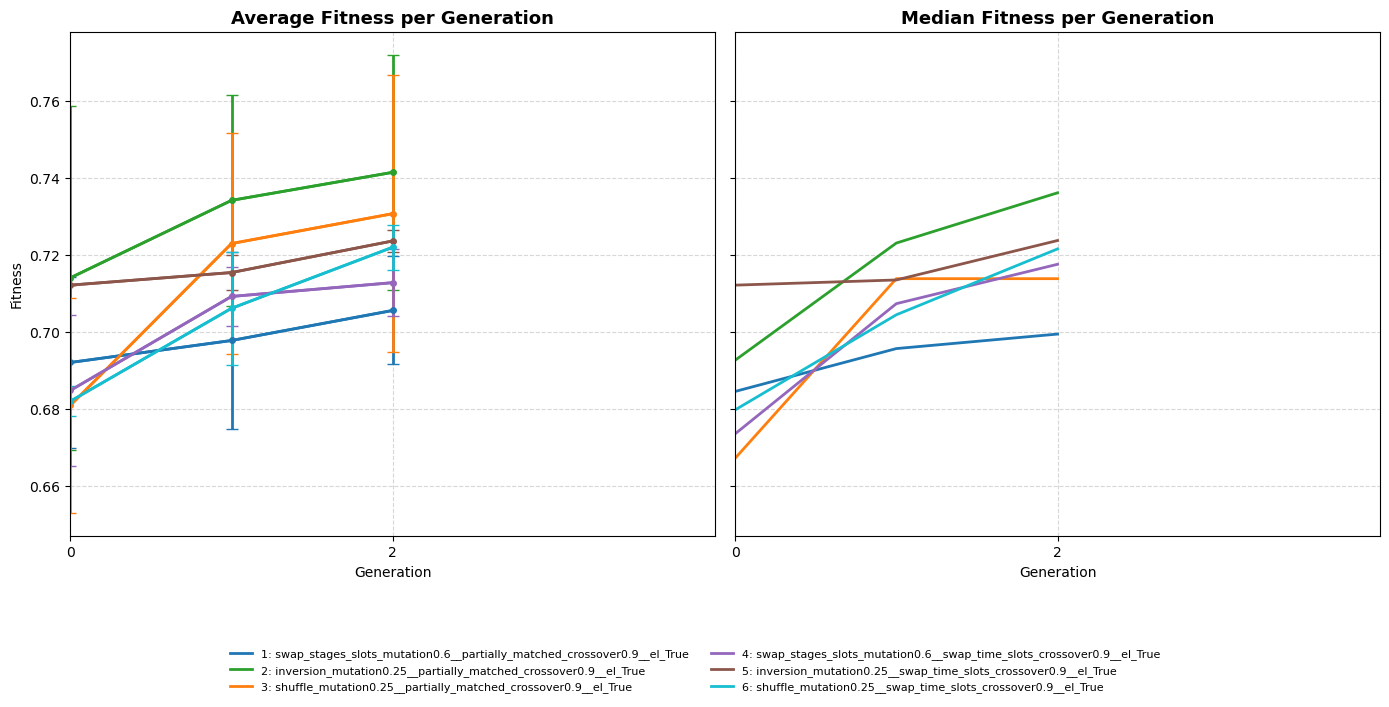

In [54]:
plot_avg_median_fit_per_generation(fitness_dfs_ga_el_true, error_bar=True)

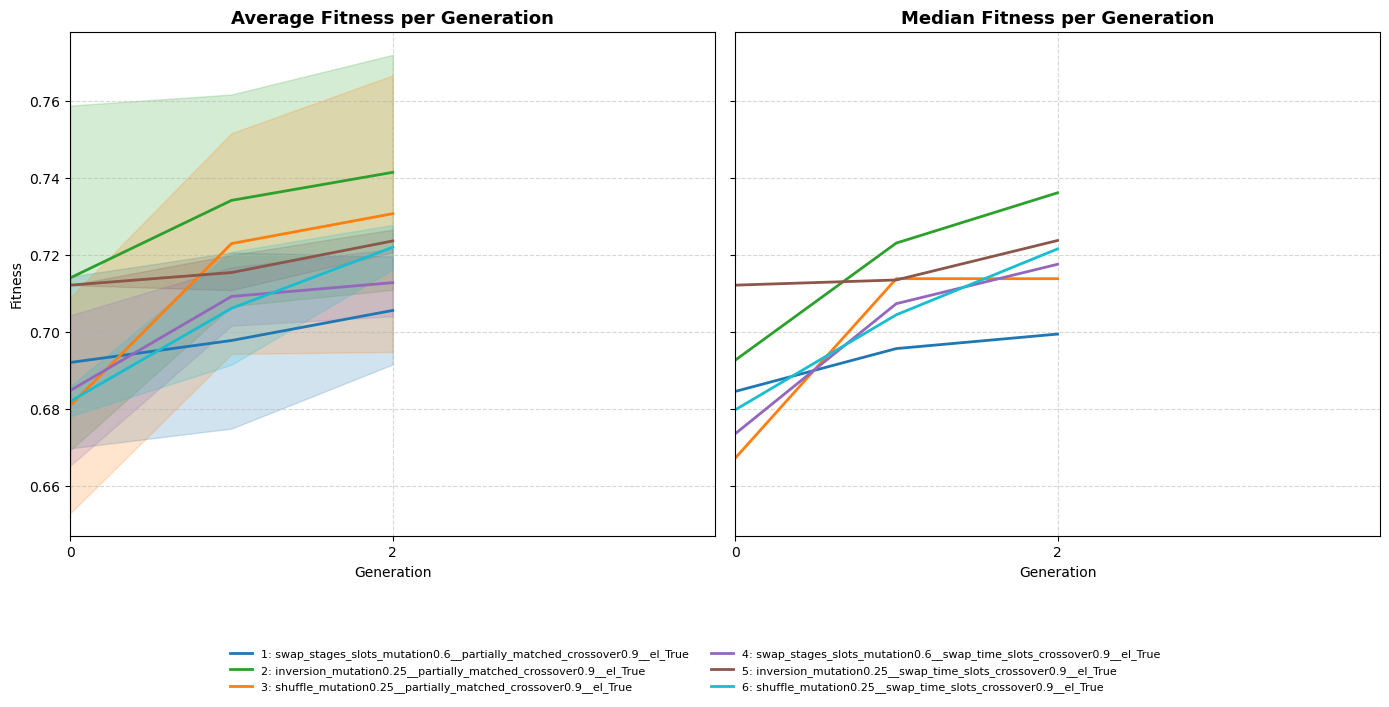

In [12]:
plot_avg_median_fit_per_generation(fitness_dfs_ga_el_true, error_bar=False)

In [13]:
def boxplots_final_fitness(results_input, legend=True, box_color="#4C72B0"):
    operator_names = []
    final_fitness_by_experiment = []

    # Validate input
    if isinstance(results_input, dict):
        for name, df in results_input.items():
            df_t = df if df.shape[0] > 1 else df.T
            final_fitness = df_t.iloc[:, -1].values
            final_fitness_by_experiment.append(final_fitness)
            operator_names.append(name)
    else:
        raise ValueError("Input must be a dict of DataFrames with final fitness values.")

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    positions = np.arange(1, len(operator_names) + 1)

    box = ax.boxplot(
        final_fitness_by_experiment,
        patch_artist=True,
        positions=positions,
        medianprops=dict(color='black'),
        whiskerprops=dict(color='gray'),
        capprops=dict(color='gray'),
        boxprops=dict(facecolor=box_color, color=box_color, alpha=0.8),
        flierprops=dict(marker='o', color='gray', alpha=0.5)
    )

    # Axes styling
    ax.set_xticks(positions)
    ax.set_xticklabels([str(i) for i in positions], fontsize=11)
    ax.set_xlabel("Experiment number", fontsize=13)
    ax.set_ylabel("Final Fitness", fontsize=13)
    ax.set_title("Final Fitness Distribution per Operator Combination", fontsize=15, weight='bold')

    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    legend_handles = [
        plt.Line2D([], [], linestyle='None', marker=None, color='none', label=f"{i}: {name}")
        for i, name in enumerate(operator_names, start=1)
    ]

    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        fontsize=10,
        ncol=2,
        frameon=False
    )

    plt.tight_layout()
    plt.show()


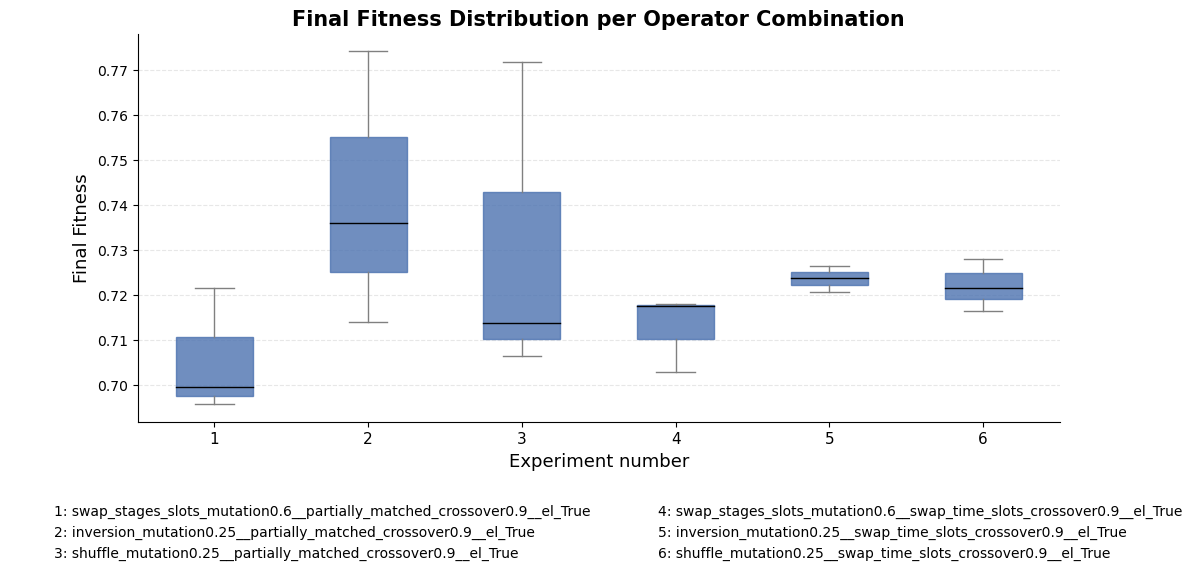

In [14]:
boxplots_final_fitness(fitness_dfs_ga_el_true)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_std_error(fitness_dfs, legend=True, marker_color="tab:blue"):
    final_means = []
    final_stds = []
    operator_names = []

    for name, df in fitness_dfs.items():
        df_t = df if df.shape[0] > 1 else df.T
        final_gen_values = df_t.iloc[:, -1].values

        final_means.append(np.mean(final_gen_values))
        final_stds.append(np.std(final_gen_values, ddof=1))
        operator_names.append(name)

    x_pos = list(range(1, len(operator_names) + 1))

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.errorbar(
        x_pos,
        final_means,
        yerr=final_stds,
        fmt='o',
        capsize=5,
        markersize=6,
        linestyle='None',
        color=marker_color,
        linewidth=2
    )

    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(i) for i in x_pos], rotation=0, fontsize=10)
    ax.set_ylabel("Fitness", fontsize=12)
    ax.set_xlabel("Experiment number", fontsize=12)
    ax.set_title("Final Generation Fitness: Mean ± Std Dev", fontsize=14, weight='bold')
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    legend_handles = [
        plt.Line2D([], [], linestyle='None', marker=None, color='none', label=f"{i}: {name}")
        for i, name in enumerate(operator_names, start=1)
    ]

    plt.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fontsize=9,
        ncol=2,              
        frameon=False
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Ensure space for legend
    plt.show()


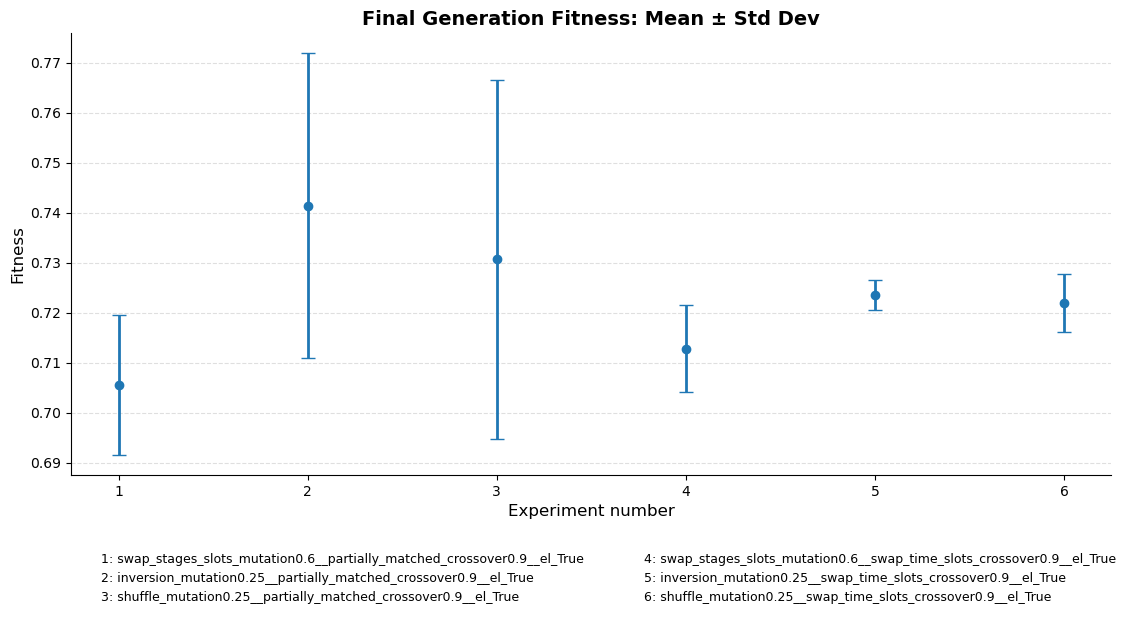

In [16]:
plot_mean_std_error(fitness_dfs_ga_el_true)

In [45]:
def avg_elapsed_time_table(all_results):
    pd.set_option('display.max_colwidth', None)
    data = []
    for result in all_results:
        data.append({
            "Experience Name": result['name'],
            "Elapsed Time Avg": result['avg_elapsed_time']
        })
    avg_elapsed_time = pd.DataFrame(data)
    avg_elapsed_time.index = range(1, len(all_results)+1)
    return avg_elapsed_time

In [46]:
avg_elapsed_time_table(all_results=all_results_test1)

,Experience Name,Elapsed Time Avg
1,swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True,7.285942
2,inversion_mutation0.25__partially_matched_crossover0.9__el_True,9.912891
3,shuffle_mutation0.25__partially_matched_crossover0.9__el_True,8.828975
4,swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True,6.343158
5,inversion_mutation0.25__swap_time_slots_crossover0.9__el_True,4.260465
6,shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True,3.840599


In [19]:
def compute_wilcoxon_pvalues(fitness_dfs):
    # Extract last generation fitness values
    fitness_last_gen = {
        name: df.T.iloc[:, -1].values if df.shape[0] == 1 else df.iloc[:, -1].values
        for name, df in fitness_dfs.items()
    }

    # Prepare pairwise comparisons
    names = list(fitness_last_gen.keys())
    p_values_table = pd.DataFrame(np.nan, index=names, columns=names)

    for i, j in itertools.combinations(range(len(names)), 2):
        stat, p = wilcoxon(fitness_last_gen[names[i]], fitness_last_gen[names[j]])
        p_values_table.loc[names[i], names[j]] = p
        p_values_table.loc[names[j], names[i]] = p

    return p_values_table.round(3)

In [20]:
compute_wilcoxon_pvalues(fitness_dfs_ga_el_true)

,swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True,inversion_mutation0.25__partially_matched_crossover0.9__el_True,shuffle_mutation0.25__partially_matched_crossover0.9__el_True,swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True,inversion_mutation0.25__swap_time_slots_crossover0.9__el_True,shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True
swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True,NaN,0.25,0.25,0.75,0.25,0.25
inversion_mutation0.25__partially_matched_crossover0.9__el_True,0.25,NaN,0.75,0.25,0.50,0.50
shuffle_mutation0.25__partially_matched_crossover0.9__el_True,0.25,0.75,NaN,0.75,1.00,1.00
swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True,0.75,0.25,0.75,NaN,0.25,0.25
inversion_mutation0.25__swap_time_slots_crossover0.9__el_True,0.25,0.50,1.00,0.25,NaN,0.75
shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True,0.25,0.50,1.00,0.25,0.75,NaN


In [21]:
grid_params = {
    "crossover": [
        {
            "function": partially_matched_crossover,
            "xo_prob": 0.9
        },
        {
            "function": swap_time_slots_crossover,
            "xo_prob": 0.9
        }
    ],
    "mutation": [
        {
            "function": swap_stages_slots_mutation,
            "mut_prob": 0.6
        },
        {
            "function": inversion_mutation,
            "mut_prob": 0.25
        },

        {
            "function": shuffle_mutation,
            "mut_prob": 0.25
        }


    ],
    "elitism": [False]
}

In [22]:
all_results_test2=[] # list to store the results for all the experiments
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))

for crossover_cfg, mutation_cfg, elitism in grid:

    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]
    experiment_name = f"{mutation_function.__name__}{mut_prob}__{crossover_function.__name__}{xo_prob}__{elitism}"
    print(f"\n\nRunning experiment: {experiment_name}")
    
    result = run_experiment_ga(
        EXPERIMENT_NAME=experiment_name,
        MUTATION_FUNCTION=mutation_function,
        CROSSOVER_FUNCTION=crossover_function,
        MUT_PROB=mut_prob,
        XO_PROB=xo_prob,
        MAX_GEN=MAX_GEN,
        NUMBER_OF_TESTS=NUMBER_OF_TESTS
    )
    all_results_test2.append(result)
    fitness_dfs[experiment_name] = result['df']




Running experiment: swap_stages_slots_mutation0.6__partially_matched_crossover0.9__False

Iteration 0 of the genetic algorithm



Final best individual in generation 1: 0.677447330603734
Final best individual in generation 2: 0.718445999089291
Final best individual in generation 3: 0.7284614641612613

Iteration 1 of the genetic algorithm

Final best individual in generation 1: 0.6932174053877908
Final best individual in generation 2: 0.7270280975071114
Final best individual in generation 3: 0.7270280975071114

Iteration 2 of the genetic algorithm

Final best individual in generation 1: 0.7038907295365177
Final best individual in generation 2: 0.7119321291735085
Final best individual in generation 3: 0.7174531781728183


Running experiment: inversion_mutation0.25__partially_matched_crossover0.9__False

Iteration 0 of the genetic algorithm

Final best individual in generation 1: 0.6792599228872188
Final best individual in generation 2: 0.6866904240572685
Final best individual in generation 3: 0.7220141894355073

Iteration 1 of the genetic algorithm

Final best individual in generation 1: 0.6658086222994946
Final be

In [23]:
print(list(fitness_dfs.keys()))

['swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True', 'inversion_mutation0.25__partially_matched_crossover0.9__el_True', 'shuffle_mutation0.25__partially_matched_crossover0.9__el_True', 'swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True', 'inversion_mutation0.25__swap_time_slots_crossover0.9__el_True', 'shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True', 'swap_stages_slots_mutation0.6__partially_matched_crossover0.9__False', 'inversion_mutation0.25__partially_matched_crossover0.9__False', 'shuffle_mutation0.25__partially_matched_crossover0.9__False', 'swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__False', 'inversion_mutation0.25__swap_time_slots_crossover0.9__False', 'shuffle_mutation0.25__swap_time_slots_crossover0.9__False']


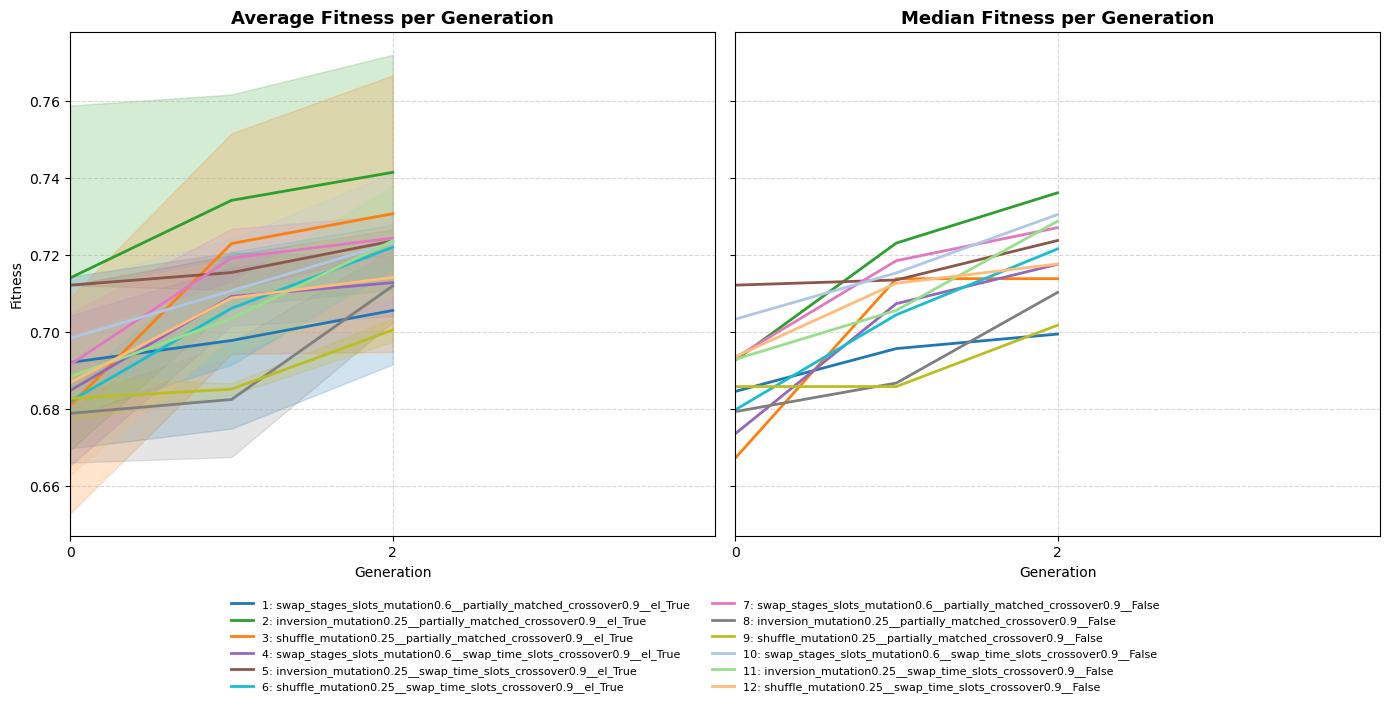

In [24]:
plot_avg_median_fit_per_generation(fitness_dfs)

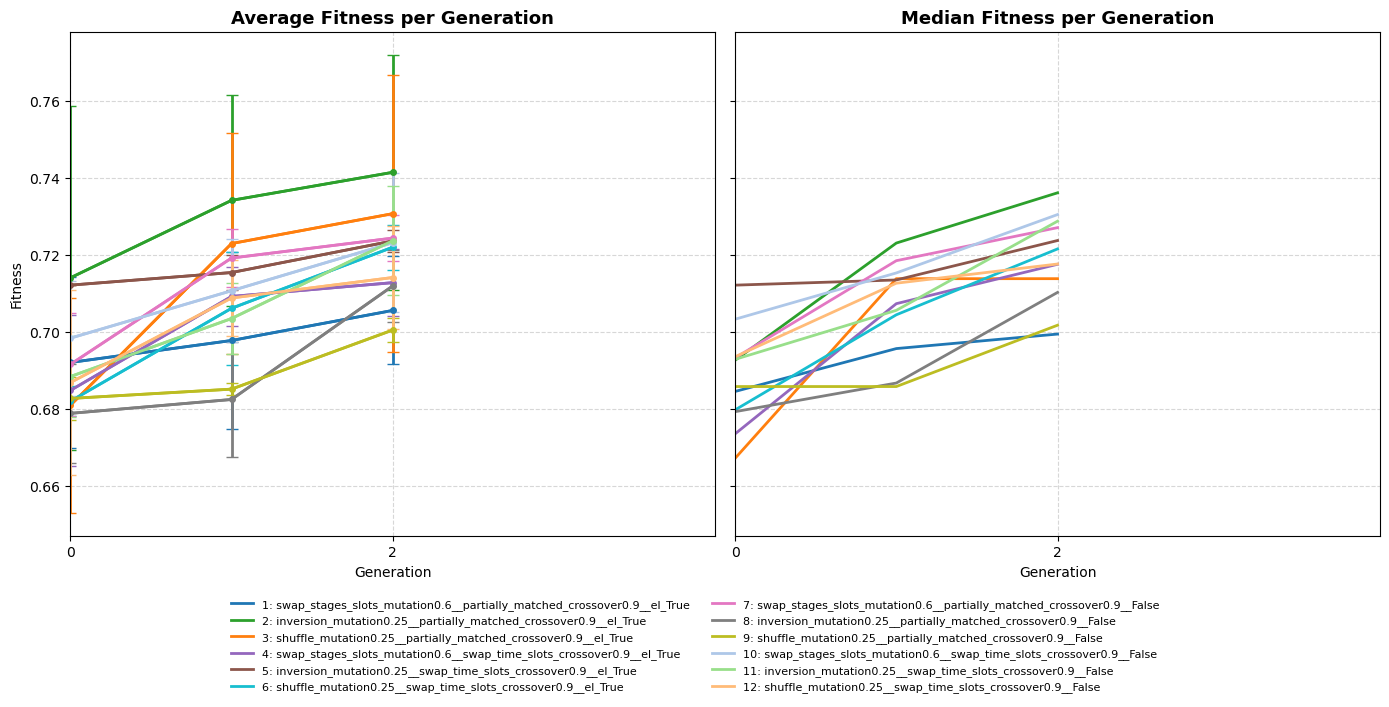

In [38]:
plot_avg_median_fit_per_generation(fitness_dfs, error_bar=True)

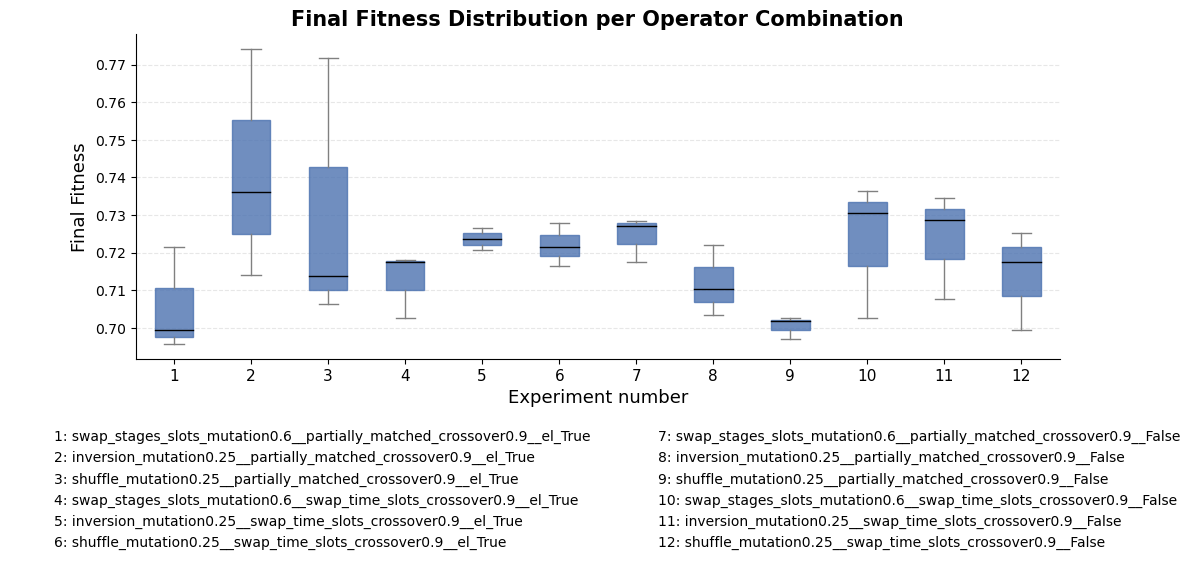

In [25]:
boxplots_final_fitness(fitness_dfs)

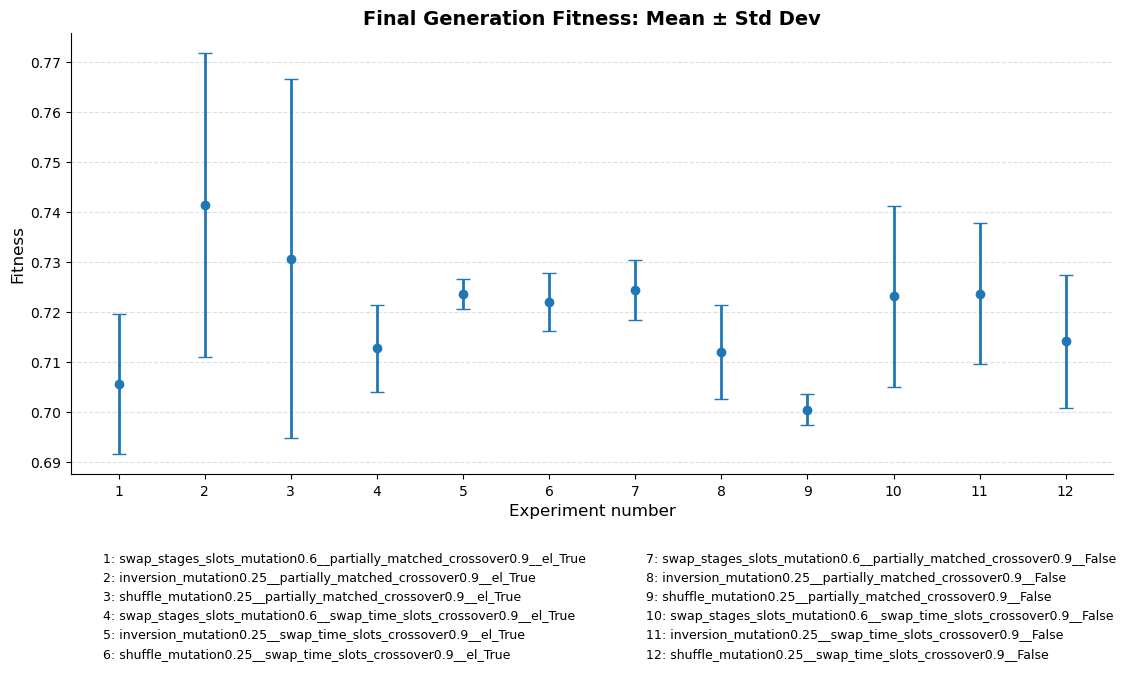

In [26]:
plot_mean_std_error(fitness_dfs)

In [47]:
avg_elapsed_time_table(all_results=all_results_test2)

,Experience Name,Elapsed Time Avg
1,swap_stages_slots_mutation0.6__partially_matched_crossover0.9__False,13.629273
2,inversion_mutation0.25__partially_matched_crossover0.9__False,6.937889
3,shuffle_mutation0.25__partially_matched_crossover0.9__False,3.488294
4,swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__False,3.239707
5,inversion_mutation0.25__swap_time_slots_crossover0.9__False,9.958285
6,shuffle_mutation0.25__swap_time_slots_crossover0.9__False,6.987051


### Test crossover and mutation probabilities

In [ ]:
# mutation_probabilities=[random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
# crossover_probabilities =[random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
# mut_funct=
# xo_funct=

In [ ]:
# all_results_test2=[]
# for mut in mutation_probabilities:
#     for xo in crossover_probabilities:
#         experiment_name = f"mutation_prob:{mut}__crossover_prob{xo}"
#         print(f"Running experiment: {experiment_name}")
        
#         result = run_experiment_ga(
#             EXPERIMENT_NAME=experiment_name,
#             MUT_PORB=mut,
#             XO_PROB=xo,
#             MUTATION_FUNCTION=mut_funct,
#             CROSSOVER_FUNCTION=xo_funct,
#             MAX_GEN=40,
#             NUMBER_OF_TESTS=2
#         )

#         all_results_test2.append(result)

In [ ]:
# plot_avg_median_fit_per_generation(all_results=all_results_test2)

In [ ]:
# boxplots_final_fitness(all_results=all_results_test2)

In [ ]:
# plot_mean_std_error(all_results=all_results_test2)

In [ ]:
# avg_elapsed_time_table(all_results=all_results_test2)

# 3. Hill Climbing

In [29]:
MAX_ITER=100
NUMBER_OF_TESTS=30

In [30]:
result_hc=run_experiment_hc(
EXPERIMENT_NAME = f"hc",
NUMBER_OF_TESTS=NUMBER_OF_TESTS,
MAX_GEN=MAX_ITER)        


Iteration 0 of the HC algorithm


Iteration 1 of the HC algorithm


Iteration 2 of the HC algorithm


Iteration 3 of the HC algorithm


Iteration 4 of the HC algorithm




Iteration 5 of the HC algorithm


Iteration 6 of the HC algorithm


Iteration 7 of the HC algorithm


Iteration 8 of the HC algorithm


Iteration 9 of the HC algorithm


Iteration 10 of the HC algorithm


Iteration 11 of the HC algorithm


Iteration 12 of the HC algorithm


Iteration 13 of the HC algorithm


Iteration 14 of the HC algorithm


Iteration 15 of the HC algorithm


Iteration 16 of the HC algorithm


Iteration 17 of the HC algorithm


Iteration 18 of the HC algorithm


Iteration 19 of the HC algorithm


Iteration 20 of the HC algorithm


Iteration 21 of the HC algorithm


Iteration 22 of the HC algorithm


Iteration 23 of the HC algorithm


Iteration 24 of the HC algorithm


Iteration 25 of the HC algorithm


Iteration 26 of the HC algorithm


Iteration 27 of the HC algorithm


Iteration 28 of the HC algorithm


Iteration 29 of the HC algorithm



# 4. Simulated Annealing

In [ ]:
MAX_ITER=100
NUMBER_OF_TESTS=30
C=[1.5, 2.5]
L=[10, 25]
H=[5, 20]

In [48]:
all_results_sa=[]
fitness_dfs_sa = {}

for c in C:
    for l in L:
        for h in H:
            experiment_name=f"sa__C_{c}__L_{l}__H_{h}"
            print(f"\n\nRunning experiment: {experiment_name}")
            result=run_experiment_sa(
            EXPERIMENT_NAME = experiment_name,
            NUMBER_OF_TESTS=NUMBER_OF_TESTS,
            MAX_GEN=MAX_ITER,
            C=c,
            L=l,
            H=h,
            VERBOSE=False)
            all_results_sa.append(result)
            fitness_dfs_sa[experiment_name]=result['df']



Running experiment: sa__C_1.5__L_10__H_5

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm



Running experiment: sa__C_1.5__L_10__H_20

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm



Running experiment: sa__C_1.5__L_25__H_5

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm



Running experiment: sa__C_1.5__L_25__H_20

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm



Running experiment: sa__C_2.5__L_10__H_5

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm



Running experiment: sa__C_2.5__L_10__H_20

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm



Running experiment: sa__C_2.5__L_25__H_5

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm



Running experiment: sa__C_2.5__L_25__H_20

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm



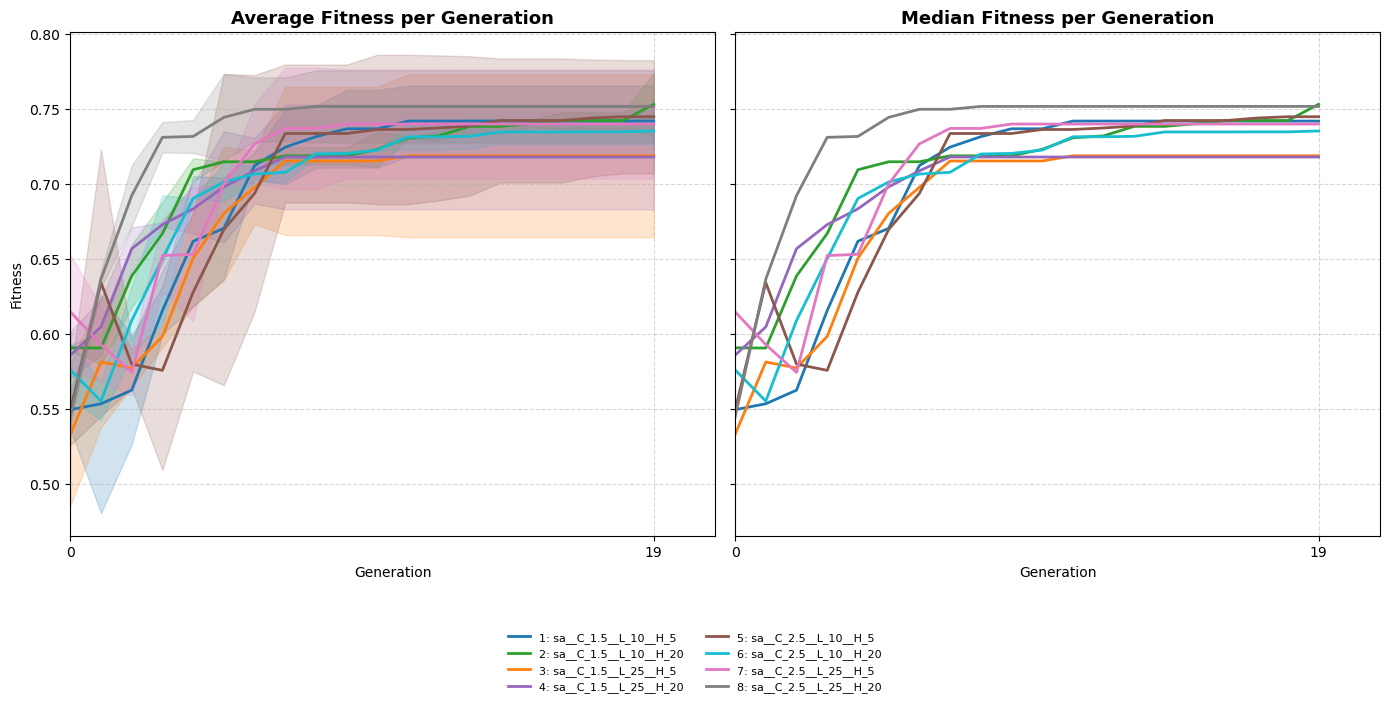

In [33]:
plot_avg_median_fit_per_generation(fitness_dfs_sa)

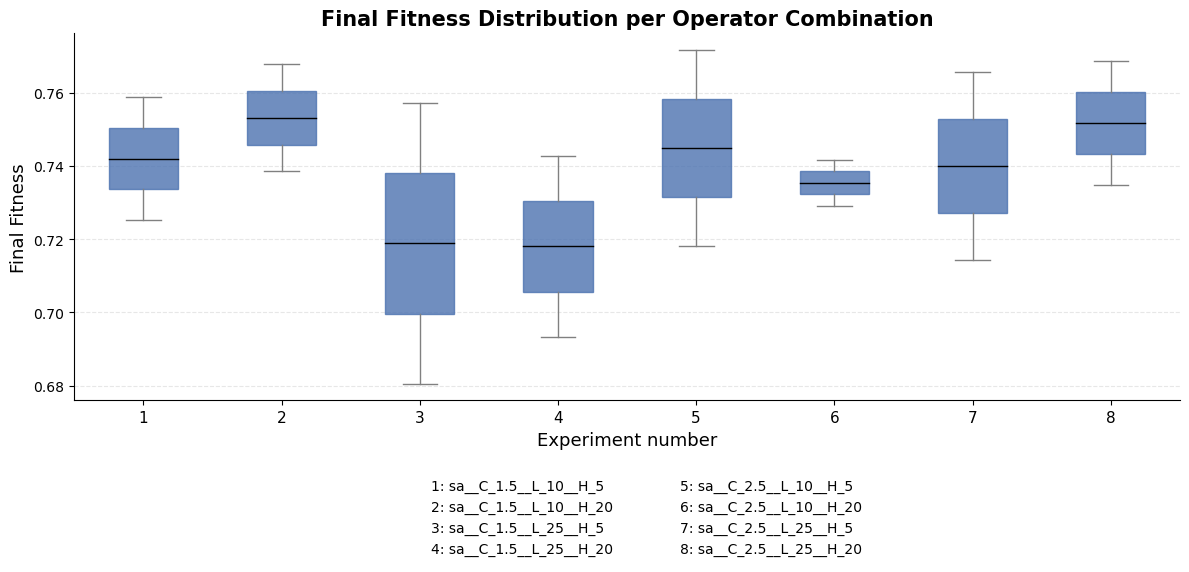

In [34]:
boxplots_final_fitness(fitness_dfs_sa)

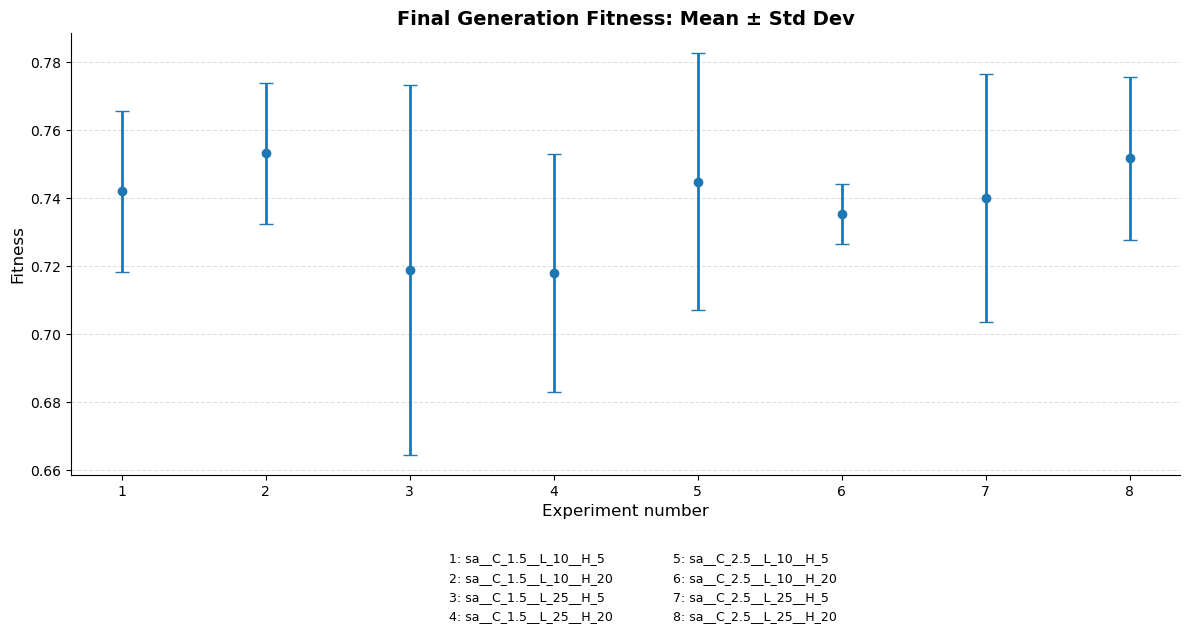

In [35]:
plot_mean_std_error(fitness_dfs_sa)

In [36]:
avg_elapsed_time_table(all_results_sa)

,Experience Name,Elapsed Time Avg
1,sa__C_1.5__L_10__H_5,0.611198
2,sa__C_1.5__L_10__H_20,0.235989
3,sa__C_1.5__L_25__H_5,0.486379
4,sa__C_1.5__L_25__H_20,0.522757
5,sa__C_2.5__L_10__H_5,0.338104
6,sa__C_2.5__L_10__H_20,0.241426
7,sa__C_2.5__L_25__H_5,0.497771
8,sa__C_2.5__L_25__H_20,0.336700


In [37]:
compute_wilcoxon_pvalues(fitness_dfs_sa)

,sa__C_1.5__L_10__H_5,sa__C_1.5__L_10__H_20,sa__C_1.5__L_25__H_5,sa__C_1.5__L_25__H_20,sa__C_2.5__L_10__H_5,sa__C_2.5__L_10__H_20,sa__C_2.5__L_25__H_5,sa__C_2.5__L_25__H_20
sa__C_1.5__L_10__H_5,NaN,0.5,0.5,0.5,1.0,1.0,1.0,0.5
sa__C_1.5__L_10__H_20,0.5,NaN,0.5,0.5,1.0,1.0,1.0,1.0
sa__C_1.5__L_25__H_5,0.5,0.5,NaN,1.0,0.5,1.0,1.0,0.5
sa__C_1.5__L_25__H_20,0.5,0.5,1.0,NaN,0.5,1.0,1.0,0.5
sa__C_2.5__L_10__H_5,1.0,1.0,0.5,0.5,NaN,1.0,1.0,1.0
sa__C_2.5__L_10__H_20,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
sa__C_2.5__L_25__H_5,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0
sa__C_2.5__L_25__H_20,0.5,1.0,0.5,0.5,1.0,1.0,1.0,NaN


# 5. Compare GA, SA and HC - TEMOS DE ALTERAR PARA AS MELHORES SOLUÇÕES


In [ ]:
results_ga_sa_hc={}
# Wrap Series into single-column DataFrames
results_ga_sa_hc['BEST_SA'] = pd.DataFrame({
    "Fitness_max": fitness_dfs_sa['sa__C_1.5__L_10__H_5_df.csv'].iloc[:, -1]
})

results_ga_sa_hc['BEST_GA'] = pd.DataFrame({
    "Fitness_max": fitness_dfs['inversion_mutation0.25__partially_matched_crossover0.9__el_True_df.csv'].iloc[:, -1]
})

# This one is already a DataFrame
results_ga_sa_hc['BEST_HC'] = result_hc['df']

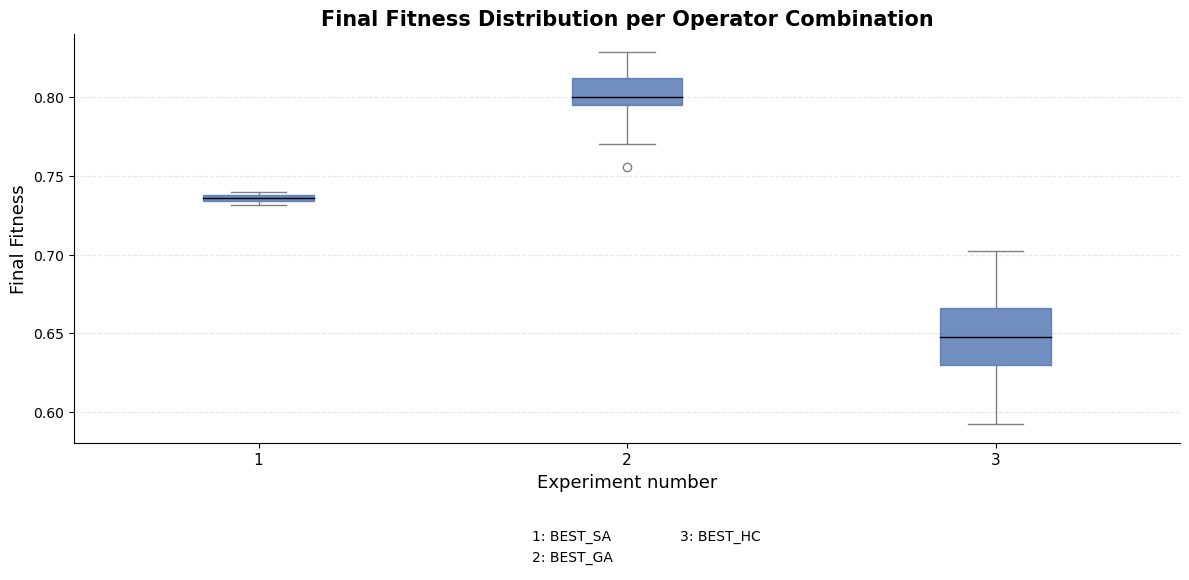

In [ ]:
boxplots_final_fitness(results_ga_sa_hc)

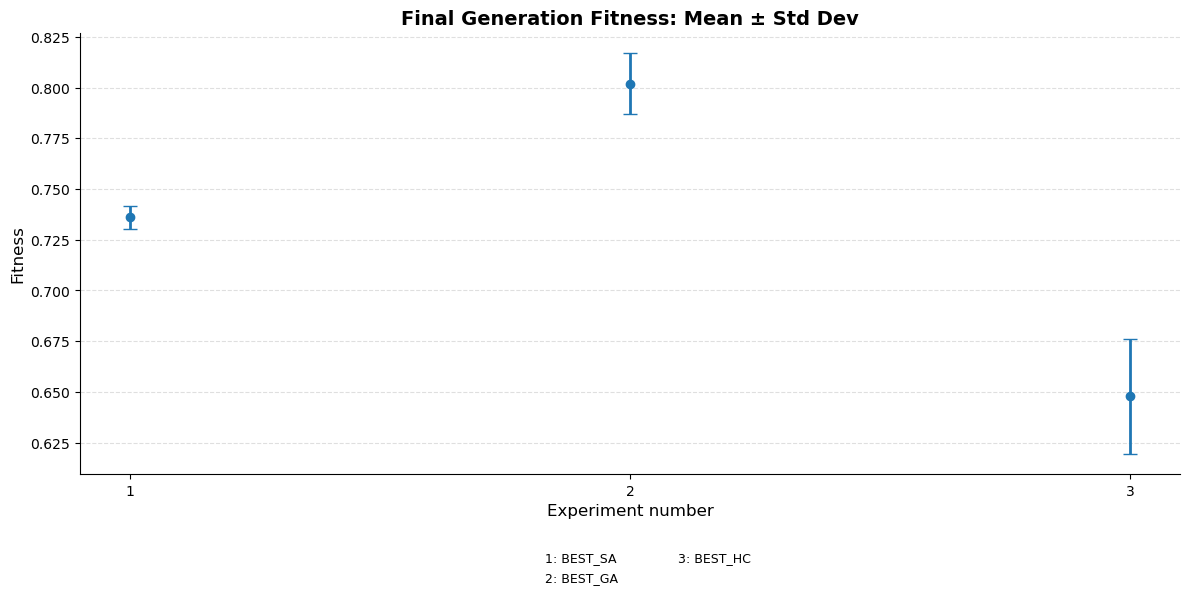

In [ ]:
plot_mean_std_error(results_ga_sa_hc)

In [ ]:
# compute_wilcoxon_pvalues(results_ga_sa_hc)

ValueError: The samples x and y must have the same length.

# Code to load all the csvs that will be generated

In [39]:
# Initialize dictionaries
fitness_dfs_sa = {}
results_hc = {}
fitness_dfs = {}

# Path to folder with CSVs (use "." for current directory)
folder_path = "./results"  # or specify: "./results" etc.

# Loop through files
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        key = filename[:-4]  # Remove ".csv"

        # Determine category by prefix
        if filename.startswith("sa"):
            fitness_dfs_sa[key] = df
        elif filename.startswith("hc"):
            results_hc[key] = df
        else:
            fitness_dfs[key] = df

In [41]:
fitness_dfs

{'inversion_mutation0.25__partially_matched_crossover0.9__el_True_df':           0         1         2
 0  0.765393  0.765393  0.774199
 1  0.692596  0.723025  0.736070
 2  0.683975  0.713900  0.713900,
 'inversion_mutation0.25__partially_matched_crossover0.9__False_df':           0         1         2
 0  0.679260  0.686690  0.722014
 1  0.665809  0.665809  0.703487
 2  0.691382  0.694771  0.710217,
 'inversion_mutation0.25__swap_time_slots_crossover0.9__el_True_df':           0         1         2
 0  0.712101  0.713445  0.726468
 1  0.712101  0.712101  0.723684
 2  0.712101  0.720572  0.720572,
 'inversion_mutation0.25__swap_time_slots_crossover0.9__False_df':           0         1         2
 0  0.692837  0.693345  0.728700
 1  0.695928  0.711404  0.734569
 2  0.676325  0.705560  0.707657,
 'shuffle_mutation0.25__partially_matched_crossover0.9__el_True_df':           0         1         2
 0  0.662379  0.699922  0.706307
 1  0.713097  0.754986  0.771876
 2  0.667144  0.713780  0.713

In [40]:
fitness_dfs_sa

{'sa__C_1.5__L_10__H_15_df':           0         1         2         3         4         5         6  \
 0  0.679488  0.626562  0.730531  0.735822  0.735888  0.735888  0.739856   
 1  0.567222  0.603228  0.644644  0.695017  0.708589  0.713787  0.713787   
 
           7         8         9  ...        40        41        42        43  \
 0  0.739856  0.757647  0.757647  ...  0.769817  0.769817  0.769817  0.769817   
 1  0.719236  0.719236  0.739099  ...  0.787249  0.787249  0.787249  0.787249   
 
          44        45        46        47        48        49  
 0  0.769817  0.769817  0.769817  0.769817  0.769817  0.769817  
 1  0.787249  0.787249  0.787249  0.787249  0.787249  0.787249  
 
 [2 rows x 50 columns],
 'sa__C_1.5__L_10__H_20_df':           0         1         2         3         4         5         6  \
 0  0.592245  0.598342  0.624002  0.652224  0.704161  0.714782  0.714782   
 1  0.589589  0.583204  0.653579  0.681894  0.714970  0.714970  0.714970   
 
           7      